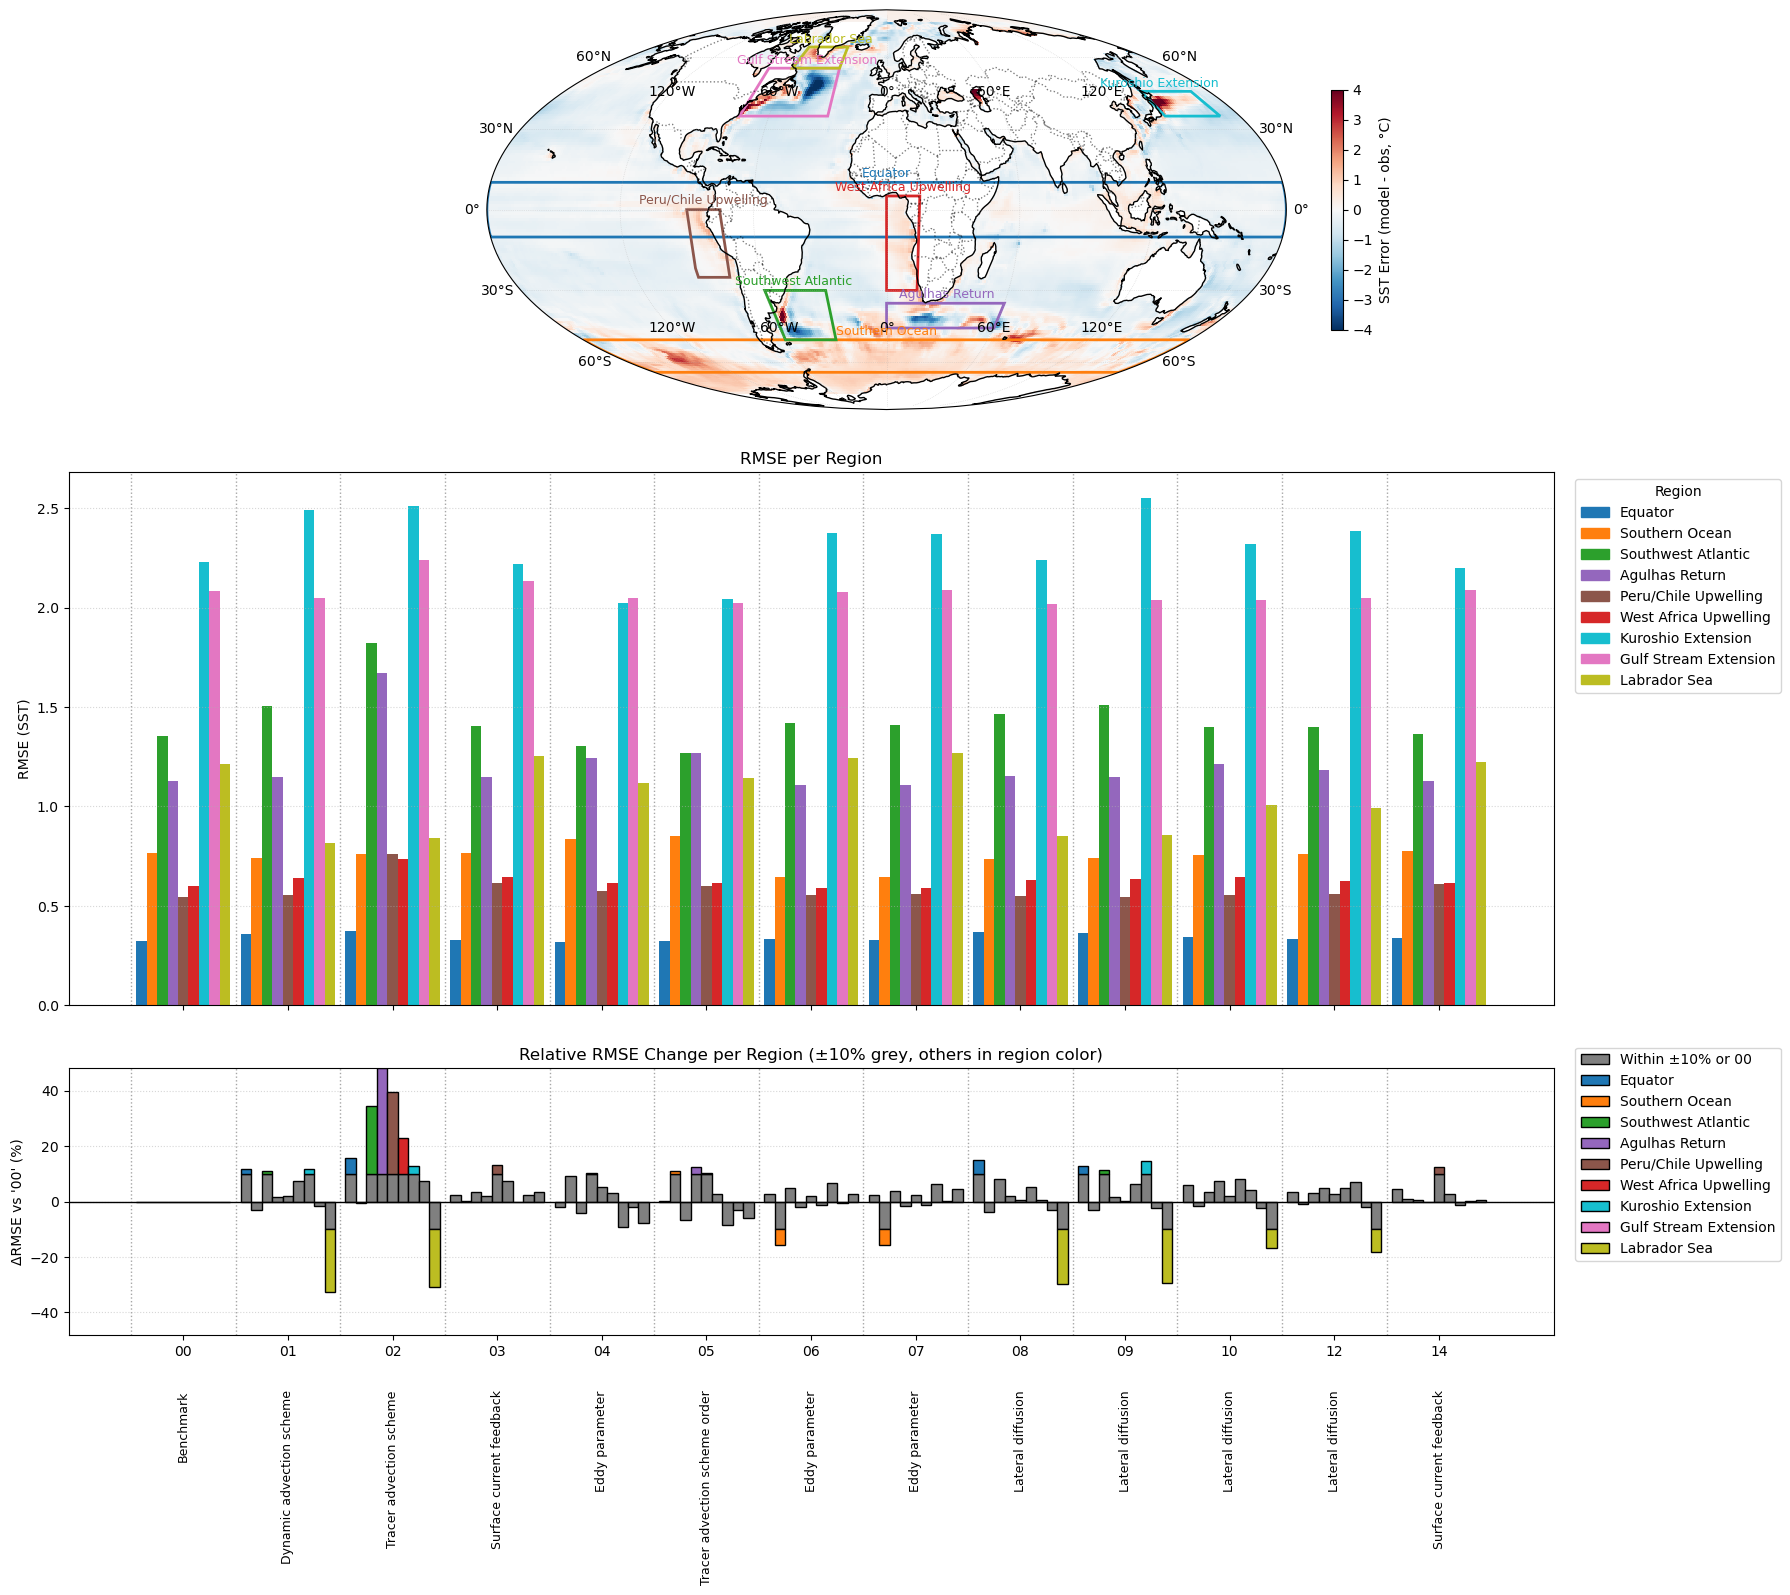

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib  

obs = xr.open_dataset("../data/processed/combined_observations.nc")

region_defs = {
    "Equator": (-10, 10, 0, 360),
    "Southern Ocean": (-65, -50, 0, 360), 
    "Southwest Atlantic": (-50, -30, 300, 330), 
    "Agulhas Return": (-45, -35, 0, 60),        
    "Peru/Chile Upwelling": (-25, 0, 270, 285), 
    "West Africa Upwelling": (-30, 5, 0, 15), 
    "Kuroshio Extension": (35, 45, 142, 170), 
    "Gulf Stream Extension": (35, 55, 285, 330), 
    "Labrador Sea": (55, 65, 300, 330),          
}
region_names = list(region_defs.keys())
region_labels = region_names  

cfgs = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "12", "14"]

# Example descriptions for configurations (replace with your own descriptions)
cfg_descriptions = [
    "Benchmark",                           # 00
    "Dynamic advection scheme",            # 01
    "Tracer advection scheme",             # 02
    "Surface current feedback",            # 03
    "Eddy parameter",                      # 04
    "Tracer advection scheme order",       # 05
    "Eddy parameter",                      # 06
    "Eddy parameter",                      # 07
    "Lateral diffusion",                   # 08
    "Lateral diffusion",                   # 09
    "Lateral diffusion",                   # 10
    "Lateral diffusion",                   # 12
    "Surface current feedback"             # 14
]

# Assign explicit colors for each region and use them throughout
region_colors = [
    "#1f77b4", # blue
    "#ff7f0e", # orange
    "#2ca02c", # green
    "#9467bd", # purple
    "#8c564b", # brown
    "#d62728", # red
    "#17becf", # cyan (for Kuroshio, not gray)
    "#e377c2", # pink
    "#bcbd22", # olive
]

rmse_results = {cfg: [] for cfg in cfgs}

for cfg in cfgs:
    ds = xr.open_dataset(f"../data/processed/nemo{cfg}.nc")
    error = ds['sst'] - obs['sst']
    rmse_points = []

    for lat_min, lat_max, lon_min, lon_max in region_defs.values():
        region_error = error.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        rmse = np.sqrt((region_error ** 2).mean())
        rmse_points.append(float(rmse.values))

    rmse_results[cfg] = rmse_points
    ds.close()

rmse_matrix = np.array([rmse_results[cfg] for cfg in cfgs])

# --- Prepare error map for '00' configuration ---
ds_00 = xr.open_dataset(f"../data/processed/nemo00.nc")
error_00 = ds_00['sst'] - obs['sst']
# Use the mean error if sst has time dimension
error_map = error_00.mean('month')
ds_00.close()

# --- Plot: Error Map with regions ---
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(3, 1, height_ratios=[1.5, 2, 1])
ax_map = fig.add_subplot(gs[0], projection=ccrs.Mollweide())
ax_map.set_global()
ax_map.coastlines()
ax_map.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax_map.gridlines(draw_labels=True, linestyle=':', linewidth=0.5, alpha=0.5)

lon2d, lat2d = np.meshgrid(error_map.lon, error_map.lat)
pcm = ax_map.pcolormesh(
    lon2d, lat2d, error_map.values,
    cmap="RdBu_r",
    vmin=-4, vmax=4,
    transform=ccrs.PlateCarree()
)
# Colorbar for the error map
cbar = plt.colorbar(pcm, ax=ax_map, orientation="vertical", shrink=0.6, pad=0.03)
cbar.set_label("SST Error (model - obs, °C)")


for i, (label, (lat_min, lat_max, lon_min, lon_max)) in enumerate(region_defs.items()):
    color = region_colors[i]
    # Special case for global-spanning regions (Equator and Southern Ocean)
    if label in ["Southern Ocean", "Equator"] and lon_min == 0 and lon_max == 360:
        rect = Rectangle((-180, lat_min), 360, lat_max - lat_min,
                         linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
        ax_map.add_patch(rect)
        ax_map.text(0, lat_max + 2, label,
                    transform=ccrs.PlateCarree(), fontsize=9, ha='center', color=color)
    else:
        # Convert lon to -180..180 if necessary for Mollweide
        lon_min_wrapped = (lon_min + 180) % 360 - 180
        lon_max_wrapped = (lon_max + 180) % 360 - 180
        width = lon_max_wrapped - lon_min_wrapped
        rect = Rectangle((lon_min_wrapped, lat_min), width, lat_max - lat_min,
                         linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree())
        ax_map.add_patch(rect)
        ax_map.text((lon_min_wrapped + lon_max_wrapped) / 2, lat_max + 2, label,
                    transform=ccrs.PlateCarree(), fontsize=9, ha='center', color=color)

# --- Plot: RMSE Bar Plot ---
ax1 = fig.add_subplot(gs[1])
n_cfg = len(cfgs)
n_aspects = len(region_labels)
x = np.arange(n_cfg)
bar_width = 0.1

for i, label in enumerate(region_labels):
    offset = -((n_aspects - 1) / 2) * bar_width + i * bar_width
    color = region_colors[i]
    ax1.bar(x + offset, rmse_matrix[:, i], bar_width, label=label, color=color)

# Remove x tick labels from ax1 (upper bar chart)
ax1.set_xticks(x)
ax1.set_xticklabels([])
ax1.set_xlabel("")
ax1.set_ylabel("RMSE (SST)")
ax1.set_title("RMSE per Region")
legend_handles = [
    Patch(color=region_colors[i], label=region_names[i]) for i in range(len(region_names))
]
ax1.legend(handles=legend_handles, title="Region", bbox_to_anchor=(1.01, 1))
ax1.grid(axis='y', linestyle=':', alpha=0.5)

# Add vertical dotted lines at config boundaries
for xi in x:
    ax1.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)

# --- Plot: Relative RMSE Plot ---
ax2 = fig.add_subplot(gs[2])
idx_00 = cfgs.index("00")
rmse_00 = rmse_matrix[idx_00]
threshold = 10

all_pcts = []
for i in range(n_aspects):
    for j in range(n_cfg):
        ref = rmse_00[i]
        val = rmse_matrix[j, i]
        pct = 0.0 if ref == 0 else (val - ref) / ref * 100
        all_pcts.append(pct)
max_pct = max(abs(np.nanmin(all_pcts)), abs(np.nanmax(all_pcts)))

for i, label in enumerate(region_labels):
    offset = -((n_aspects - 1) / 2) * bar_width + i * bar_width
    base_color = region_colors[i]
    for j in range(n_cfg):
        ref = rmse_00[i]
        val = rmse_matrix[j, i]
        pct = 0.0 if ref == 0 else (val - ref) / ref * 100

        if cfgs[j] == "00":
            ax2.bar(j + offset, 0, bar_width, color="grey", edgecolor='black', zorder=1)
        elif abs(pct) <= threshold:
            ax2.bar(j + offset, pct, bar_width, color="grey", edgecolor='black', zorder=1)
        else:
            ax2.bar(j + offset, np.sign(pct) * threshold, bar_width, color="grey", edgecolor='black', zorder=1)
            ax2.bar(j + offset, pct - np.sign(pct) * threshold, bar_width,
                    color=base_color, bottom=np.sign(pct) * threshold, edgecolor='black', zorder=2)

ax2.axhline(0, color='black', linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(cfgs)
ax2.set_xlabel("")
ax2.set_ylabel("ΔRMSE vs '00' (%)")
ax2.set_title("Relative RMSE Change per Region (±10% grey, others in region color)")
ax2.set_ylim(-max_pct, max_pct)
ax2.grid(axis='y', linestyle=':', alpha=0.5)

# Add vertical dotted lines at config boundaries in lower chart
for xi in x:
    ax2.axvline(x=xi-0.5, color='grey', linestyle=':', linewidth=1, alpha=0.7, zorder=0)

# Add vertical configuration description on the right of the lower bar chart
for j, desc in enumerate(cfg_descriptions):
    ax2.text(j, -max_pct-20, desc, rotation=90, fontsize=9, va='top', ha='center')

legend_elements = [
    Patch(facecolor='grey', edgecolor='black', label='Within ±10% or 00')
]
for i, label in enumerate(region_labels):
    legend_elements.append(Patch(facecolor=region_colors[i], edgecolor='black', label=f'{label}'))

ax2.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1.01, 0.25))

plt.tight_layout()
plt.show()

# Comments

- 08, 09 vs 10, 12 : bilaplacian has a smoother impcat
- 08 vs. 09: Kuroshio with significant difference
- 08 : too much diffusivity kills the currents which follow along the equator?
- surface current feedback has only a positive impact, in particular in Peru/Chile coast